# [FSQ] TfIdf and Sukarno-Hatta Airport

# Credit to the following link  
(for the method to use BallTree)  
https://www.kaggle.com/code/andypenrose/spatial-neighbours-benchmark-name-and-category  

# Introduction

We can see the following explanation in the introduction of this competition, but at first, honestly I was not able to fully understand what this competion aims. However, I've got it when I encountered below **"In10/Out10" cell** which is the analysis for **Sukarno-Hatta Airport** in Jakarta. 

> ・When you look for nearby restaurants or plan an errand in an unknown area, you expect relevant, accurate information. To maintain quality data worldwide is a challenge, and one with implications beyond navigation.   
> ・In this competition, you’ll match POIs together. Using a dataset of over one-and-a-half million Places entries heavily altered to include noise, duplications, extraneous, or incorrect information, you'll produce an algorithm that predicts which Place entries represent the same point-of-interest.  

From this Sukarno-Hatta Airport example, we can know People do not necessarily indicate exactly same name when they want to go to the same place. So, it'd be better to ease the name-similarity rather than perfect-matching, however, if you ease the similarity too much it would lead to lower matching.  I used TfIDF+Cosine_similarity to measure the similarity.  

このコンペの紹介には以下のような記述があり、points-of-interest (POI)をマッチさせるコンペということなのですが、イマイチ、ピンときませんでした。が、以下の**セル「In10/Out10」でスカルノ・ハッタ空港（ジャカルタ）** の例を見て、”あー、なるほど！”と理解できました。  

> ・近くのレストランを探したり、未知のエリアで用事を計画したりするときは、関連性のある正確な情報が期待されます。世界中で高品質のデータを維持することは課題であり、ナビゲーションを超えた意味合いを持つものです。  
> ・このコンペティションでは、POIを一緒にマッチさせます。ノイズ、重複、余分な情報、または誤った情報を含むように大幅に変更された 150 万を超える Places エントリのデータセットを使用して、どの Place エントリが同じ関心ポイントを表すかを予測するアルゴリズムを生成します。  

スカルノ・ハッタ空港の例を見て分かる通り、人は同じ場所に行くときに必ずしも同じ名称を指定するとは限りません。なので、目的地の名称の類似度は完全一致ではなく、多少緩くしたほうがマッチ度は上がるものの、緩くしすぎると無関係の場所までマッチさせてしまいマッチ度が下がることが分かります。類似度の測定には、文章の類似度を測る際に用いられるTfIdfとCosine_similarityを使ってみました。  

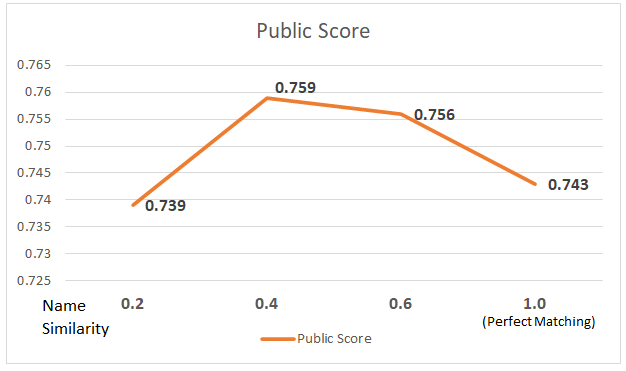


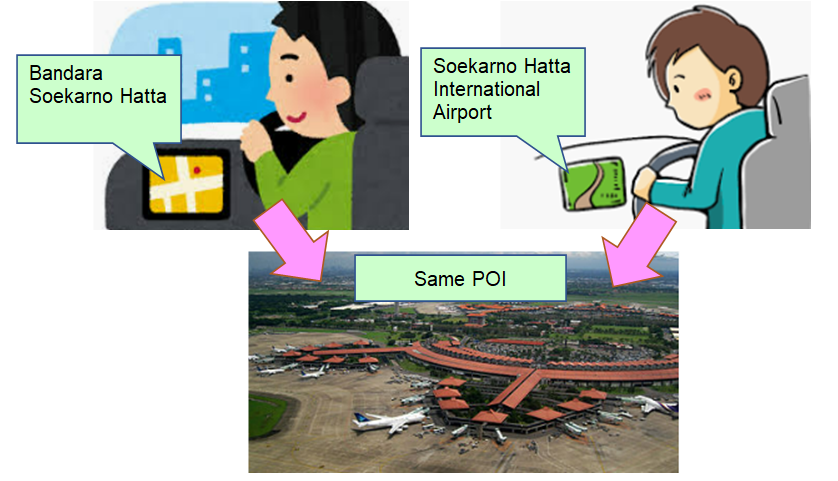

# 1. Read data

In [ ]:
import numpy as np
import pandas as pd 
from sklearn.neighbors import BallTree
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
pd.set_option("display.max_columns", None)

In [ ]:
train_df = pd.read_csv('../input/foursquare-location-matching/train.csv')
test_df = pd.read_csv('../input/foursquare-location-matching/test.csv')
pairs_df = pd.read_csv('../input/foursquare-location-matching/pairs.csv')
sample_submission = pd.read_csv('../input/foursquare-location-matching/sample_submission.csv')

In [ ]:
train_df

In [ ]:
test_df.head()

In [ ]:
sample_submission

**How many POI's exist?**

As you can see avobe, both Train-data and Test-data includes the details of POI such as name of shops or restaurant, or location (latitude/longitude). Also, Train-data includes POI's ID information in the very right-hand column.  
The number of unique POI ID is about 739thou while the number of all Train-data records is 1,138thou, hence you can know there exist duplicate records which have the same POI. It seems these recods means "POI matches".  

以上のように、Trainデータ、Testデータともに、目的地（主に店やレストラン）とその位置情報（緯度・経度）を含んでおり、Trainデータには「Point-of-interest(POI)（関心のある地点）」のIDが付与されている。　Trainデータの113万レコードに対し、ユニークなPOIは74万個ほど存在するので、同じPOIをもつレコードが重複して存在していることが分かる。この重複しているレコードが「POIがマッチしている」ということだろう。

In [ ]:
len(train_df["point_of_interest"].unique())

Let's see how duplicate POIs are. 

POIの重複具合をもう少し詳しく見てみよう。

In [ ]:
temp_df = pd.DataFrame(train_df.groupby("point_of_interest")["id"].count().reset_index())
temp_df

You can understand that the POI P_00000458b5ff8e has only 1 while the next POI P_00001c309a5e0a has 4 records. We could understand these 4 records have different POI information but ultimately indicate the same single point.  
Let's see more in detail.

なるほど、一番上のP_00000458b5ff8eは、Trainデータの中にPOIが1レコードしか存在していないし、次のP_00001c309a5e0aは4レコードも存在している。 つまり、この4レコードはPOI情報は異なるものの、同じ地点を指している、ということらしい。  
もう少し詳しく見てみよう。

In [ ]:
temp_df.describe()

We can see more than half of POIs have only 1record, and when we check 3/4 of all records we can see the 2-record POI..... but, wait a moment! you notice a POI which has **332** records in Train data. The POI is P_fb339198a31db3.

POIは半分以上が1レコードのみで、3/4まで見てみると2レコード存在するものが出てくるが・・・・ちょっと待て、なんだ？1つのPOIで**332**レコードも存在するものがあるぞ。そのPOIは、P_fb339198a31db3だ。

In [ ]:
temp_df[temp_df["id"]==332]

In [ ]:
train_df[train_df["point_of_interest"] =="P_fb339198a31db3"]

# 2. Insight from Sukarno-Hatta Airport

When extract these 332records which has the same POI, you can see this is Sukarno-Hatta Airport in Jakarta, Indonesea.  
Maybe it is the easiest way to imagine the situation that you input the destination into the Car-navigation screen.  
Sukarno-Hatta airpot is locally called Bandar Udara Internasional Soekarno-Hatta, so various people input the name in the various way such as "Sukarno Hatta" or "Bandar Djakarta", etc.  
Also we can notice the categories are also various, e.g. Bakeries or Food Courts, etc.  This means pepole go there not only for taking a airplane but also for various purpose. This would be why 332 records which have various names or categories ultimately indicate the same point.

このPOIをもつ332レコードを見てみると、インドネシアの首都ジャカルタのスカルノ・ハッタ国際空港であることが分かる。  
カーナビに目的地をセットする場面を想像するのが一番分かりやすいのだろうが、スカルノ・ハッタ国際銀行は現地ではBandar Udara Internasional Soekarno-Hattaと呼ばれているらしいし、同じ目的地を入力するにしても、「Sukarno Hatta」と入れたり「Bandar Djakarta」と入れたり、いろんな入力の仕方があるのだろう。また、以下のように、BakeriesやFood Courtsといった様々なカテゴリーが存在するので、単に飛行機に乗るためだけではなく、様々な目的で空港にいくことが分かる。なので、名称や目的が異なる332もの入力が結局は同じ1つの地点を指している、ということだろう。  

In [ ]:
hatta_df = train_df[train_df["point_of_interest"] =="P_fb339198a31db3"]
hatta_df["categories"].unique()

# 3. Modelling approach

The aim of this competition is to "match the POIs". From a look at the above Sukarno-Hatta example, the below approch seems good.  

 (1) Name is similar, and the distance is relatively near  
   It may be rare case that multiple shops which have the same name in the near area,  
   hence we may not need to narrow down the distance.  
   Also, the name may not need to be exactly same, hence we could use Cosine similarity method with TfIdf.   
 (2) Name is not similar(like Sukarno-Hatta and Bandar Udara), but categories are same and geographicaly same location  
   It is very frequent that multiple same-category shops exist in near area, hence we should narrow down the distance.  


このコンペの目的は「POIをマッチさせる」ということだが、上記のスカルノ・ハッタ空港の例から以下の２つのアプローチが有効そうだ。  
　(1) 名前が似ていて、距離も比較的近い  
 　　　距離は少し離れていてもその範囲に同じ名前の店が存在することはあまりないと思われる。  
    　　　店・施設の名前が完全一致している必要もないと思われるので、TfIdfとCosine類似法で「似ている」かどうかの判定を行う。  
　(2) 名前は似ていない（Sukarno-HattaとBandar Udaraのように）が、カテゴリー（Airport）が同じで距離的にもほぼ同地点  
 　　　狭い範囲に同じカテゴリーの店が集中していることはよくあるので、(1)よりも距離は狭める必要あり。

In [ ]:
def vecs_array(documents):   
    docs = np.array(documents) 
    vectorizer = TfidfVectorizer()
    vecs = vectorizer.fit_transform(docs)    
    return vecs.toarray()

def simil_score (doc_list):    
    docs_array = np.round(cosine_similarity(vecs_array(doc_list), vecs_array(doc_list)),3)
    score = docs_array[0,1]
    return score

Let's take a look at the name-similarity for index 14686 "Bandara Soekarno Hatta" and Soekarno Hatta International Airport.  The similarity will show 0.411.

試しに、Bandara Soekarno Hatta（14686）とSoekarno Hatta International Airport（1120868）の類似度を見てみると、0.411となる。

In [ ]:
#temp_namelist = []
#temp_namelist.append(hatta_df.loc[14686, 'name'])
#temp_namelist.append(hatta_df.loc[1120868, 'name'])
#print(simil_score (temp_namelist))

In [ ]:
test_df["categories"] = test_df["categories"].fillna('__NAN__')
test_df["name"] = test_df["name"].fillna('__NAN__')

In [ ]:
tree = BallTree(np.deg2rad(test_df[['latitude', 'longitude']].values), metric='haversine')

In [ ]:
pois_out = []
max_poi = 2
n = min(10, len(test_df))

max_dist_catg = 0.0005
max_dist_name = 0.005
max_dist = max(max_dist_catg, max_dist_name)

for i, row in test_df.iterrows():
    distance, indices = tree.query(np.deg2rad(np.c_[row['latitude'], row['longitude']]), k = n)  
        
    poi = []
    for dist, j in zip(distance[0], indices[0]):       
 
        name_list = []
        name_list.append(row['name'].lower())
        name_list.append(test_df["name"].iloc[j].lower())        
        
        try :
            simil_score(name_list)
        except ValueError :
            break
        else :
            if dist <= max_dist_catg and row['categories'] != '__NAN__' and (row['categories'] in test_df.categories.iloc[j] or test_df.categories.iloc[j] in row['categories']):
                poi.append(test_df.id.iloc[j])
            elif dist <= max_dist_name and row['name'] != '__NAN__' and simil_score(name_list) > 0.4:
                poi.append(test_df.id.iloc[j]) 
            if dist > max_dist or len(poi) >= max_poi:
                break

    if len(poi) == 0:
        pois_out.append(row['id'])        
    else:
        pois_out.append(' '.join(poi))        

In [ ]:
sample_submission.matches = pois_out
sample_submission.head()

In [ ]:
sample_submission.to_csv('submission.csv', index=False)